In [1]:
# Import important library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, KFold, cross_val_score,cross_val_predict
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder()
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.utils import resample

from scipy.stats import zscore

### Read the input file and check the data dimension

In [2]:
data = pd.read_csv('german_credit.csv')

In [3]:
# You can access from https://www.kaggle.com/uciml/german-credit
#Read input file and understand the data
# "default" is my dependent variable

In [4]:
data_copy=data.copy()
y=data.pop('default')
X=data

### Q1 Randomly select 50% data for this use case( 1 Marks)
###### Hint: Use train_test_split

In [5]:
X1_train,X1_test,y1_train,y1_test = train_test_split(X,y,test_size=0.5,random_state=1)

Lets build a Ensemble model but need to modify the dataset first

### Q2.Prepare the model data by converting non-numeric to dummy ( 1 Marks)
##### Hint: Use get_dummies

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
account_check_status          1000 non-null object
duration_in_month             1000 non-null int64
credit_history                1000 non-null object
purpose                       1000 non-null object
credit_amount                 1000 non-null int64
savings                       1000 non-null object
present_emp_since             1000 non-null object
installment_as_income_perc    1000 non-null int64
personal_status_sex           1000 non-null object
other_debtors                 1000 non-null object
present_res_since             1000 non-null int64
property                      1000 non-null object
age                           1000 non-null int64
other_installment_plans       1000 non-null object
housing                       1000 non-null object
credits_this_bank             1000 non-null int64
job                           1000 non-null object
people_under_maintenance      100

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
duration_in_month,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0
credit_amount,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
installment_as_income_perc,1000.0,2.973,1.118715,1.0,2.0,3.0,4.00,4.0
present_res_since,1000.0,2.845,1.103718,1.0,2.0,3.0,4.00,4.0
age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0
credits_this_bank,1000.0,1.407,0.577654,1.0,1.0,1.0,2.00,4.0
people_under_maintenance,1000.0,1.155,0.362086,1.0,1.0,1.0,1.00,2.0


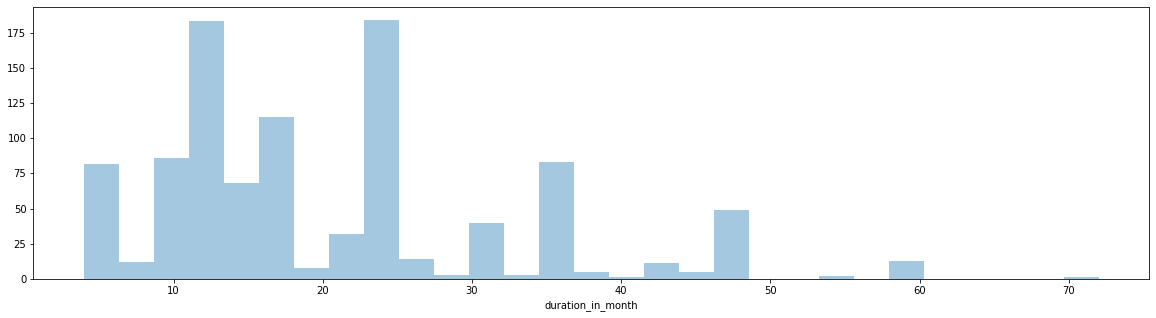

In [8]:
plt.figure(figsize=(20,5))
sns.distplot(data['duration_in_month'],kde=False)

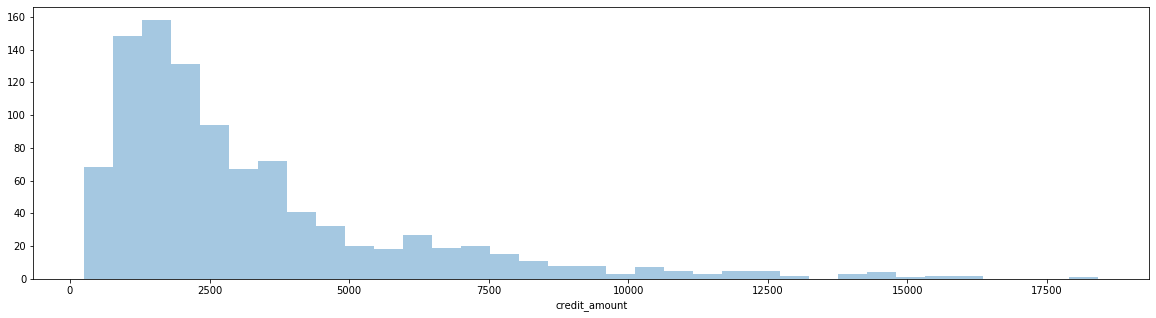

In [9]:
plt.figure(figsize=(20,5))
sns.distplot(data['credit_amount'],kde=False)

The distribution is highly right-skewed, with a large number of people having a credit_amount less than 2500. However, there are people having a high credit-amount, as high as more than 17500

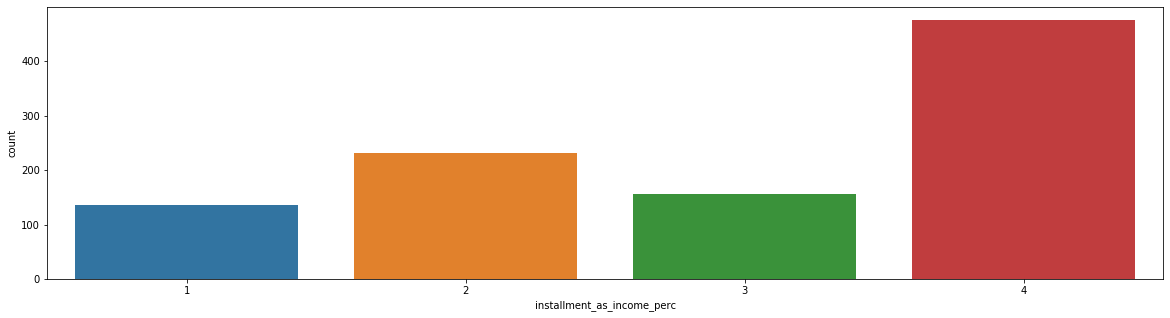

In [10]:
plt.figure(figsize=(20,5))
sns.countplot(data['installment_as_income_perc'])

This feature, although captured as a continuous numerical data, is actually categorical in nature. The distribution is highly skewed, with a major portion of the data (almost half of the data) has 4% installment amount as their income

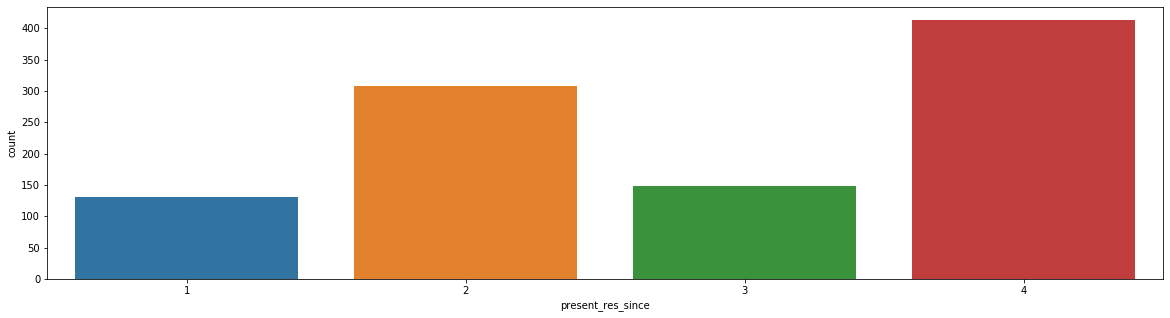

In [11]:
plt.figure(figsize=(20,5))
sns.countplot(data['present_res_since'])

In this case too the data is highly skewed, with a majority of the population having a residency of 4 years. This is followed by people residing for last 2 years. The distribution of people residing for last 3 years & 1 year is similar

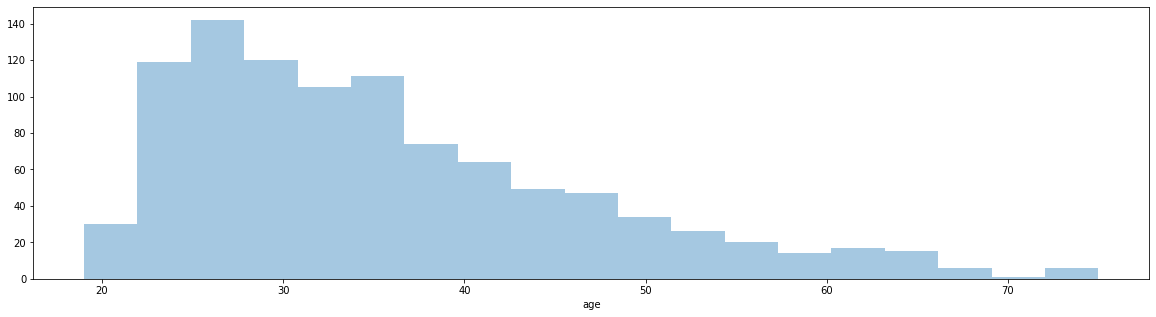

In [12]:
plt.figure(figsize=(20,5))
sns.distplot(data['age'],kde=False)

The AGE data is again highly right-skewed, with a majority of the dataset capturing people of ages 20-35 years. However there are quiet a number of people beyond that age group too, with even a sudden rise beyond 70 years

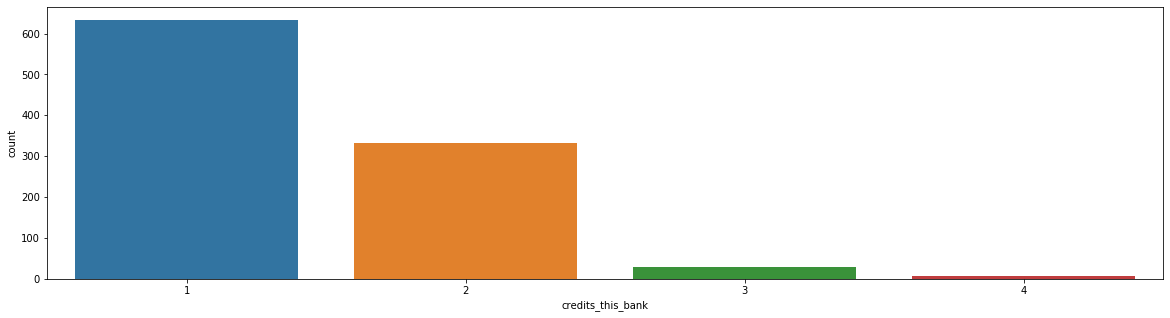

In [13]:
plt.figure(figsize=(20,5))
sns.countplot(data['credits_this_bank'])

This feature too is skewed, with a more than half of the dataset having people having 1 credit with the subject Bank. However, what's interesting is the huge drop from 2 to 3 credits. It seems, the dataset represents people being reasonable enough to restrict their number of credits to 2, with only a small population taking 3 credits & an even smaller number taking 4 credits. 

However, we need to see whether there is any correlation between this decision/trend with other features like SAVINGS, people_under_maintenance, CREDIT_AMOUNT etc. Also, low number of credits with this Bank doesn't necessarily mean that there is no other credits elsewhere

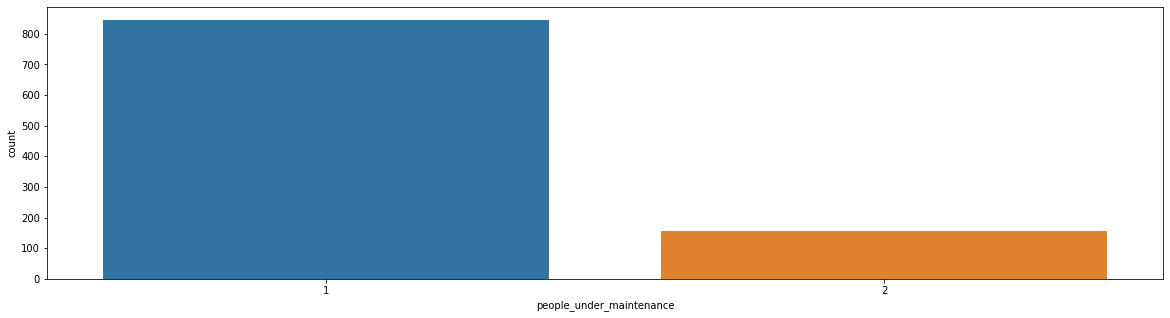

In [14]:
plt.figure(figsize=(20,5))
sns.countplot(data['people_under_maintenance'])

**It seems all data in this dataset is skewed. :-)**

The number of people having only 1 people under maintenance absolutely over-shadows the number of people having 2 people. This ratio seems to be almost 8:1, which shows the level of skewness

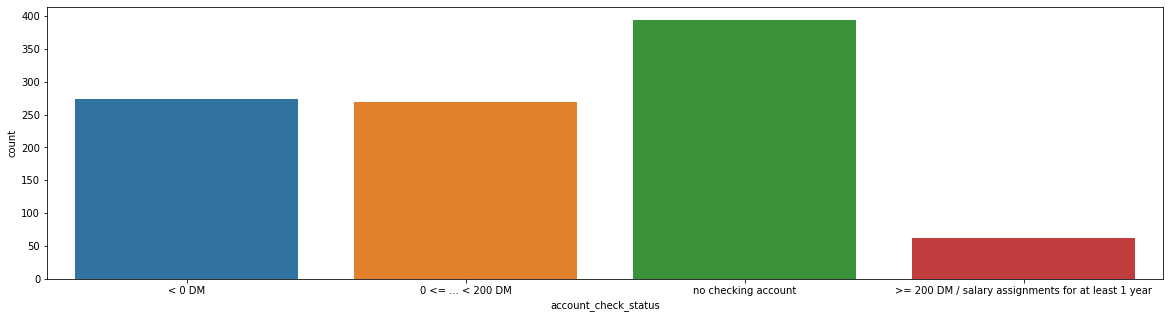

In [15]:
plt.figure(figsize=(20,5))
sns.countplot(data['account_check_status'])

The number of people having negative balance in their checking account is almost proportional to the number of people having less than 200 DM. However, it's worrying as to why so many people would be having negative balance in their a/c. We may have to investigate whether all of these people are having credits with this Bank & their CREDIT-HISTORY. Are all these people defaulters too?

However, it's even more worrying that majority of people don't even have a checking account with the Bank, and yet they feature in this dataset. We may have to investigate whether all of these people are having credits with this Bank & their CREDIT-HISTORY, like people who have negative balance in their accounts. Are all these people defaulters too?

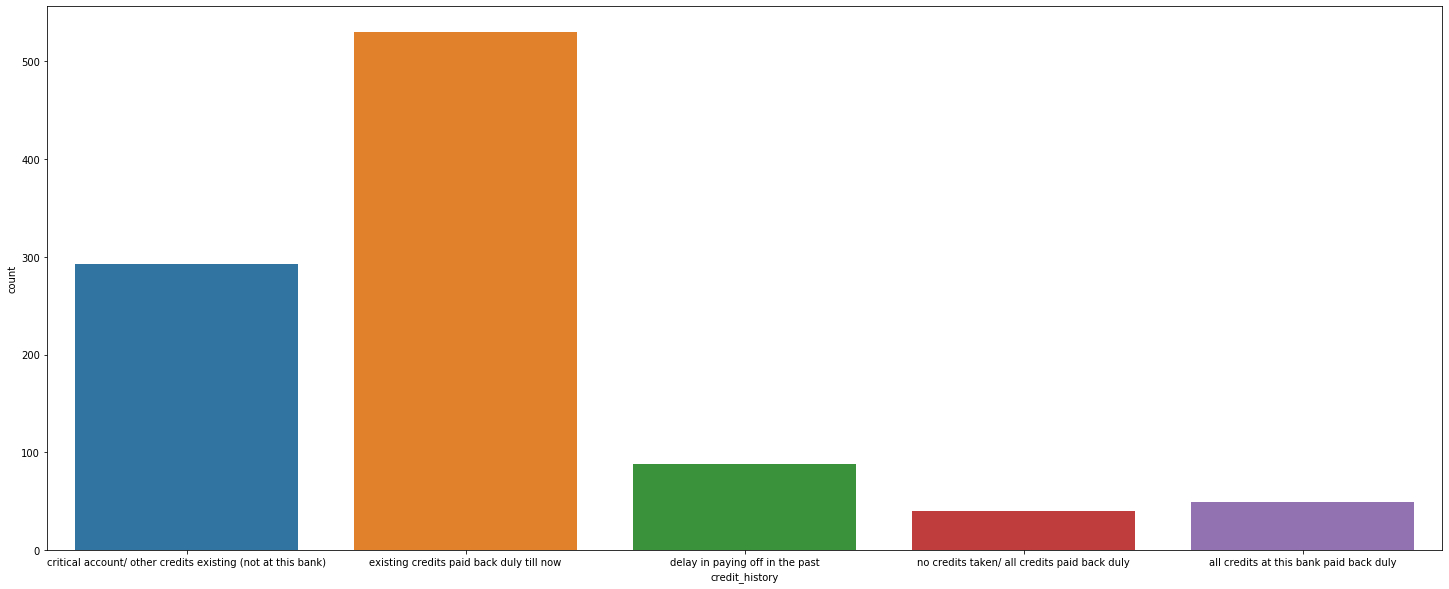

In [16]:
plt.figure(figsize=(25,10))
sns.countplot(data['credit_history'])

Finally we have some sign of relief as the proportion of people who have either paid back all existing credits, both ath this Bank as well as elsewher, on time or have not taken any credits at all is quiet significant to the proportion of people who have credits in critical condition. 

However, this number is also not insignificant, as we can see from above that this number is quiet high as 40%(critical account+delay in payment of past credits) of the population

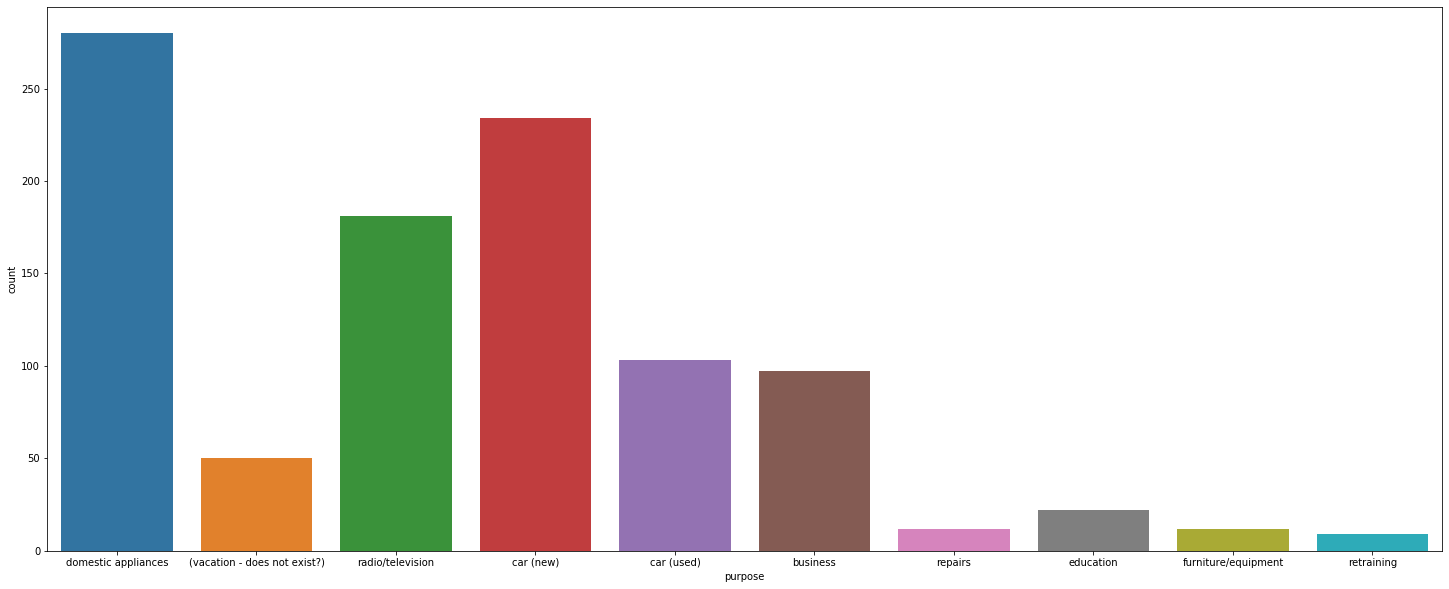

In [17]:
plt.figure(figsize=(25,10))
sns.countplot(data['purpose'])

The above plot gives a picture of what people have actually utilised their credits for.

Most people have used it for either purchasing domestic appliances, followed by car, radio/television & then used cars. So the volume of high-value credits (cars,business,education) is quiet small compared to that of low-value credits like domestic appliances,radio/television,furniture/equipment etc.

Thus we may need to introspect whether these credits were sanctioned through credit cards or through loans. While the big-ticket items may have required loans, the latter should have been fulfilled by credit cards

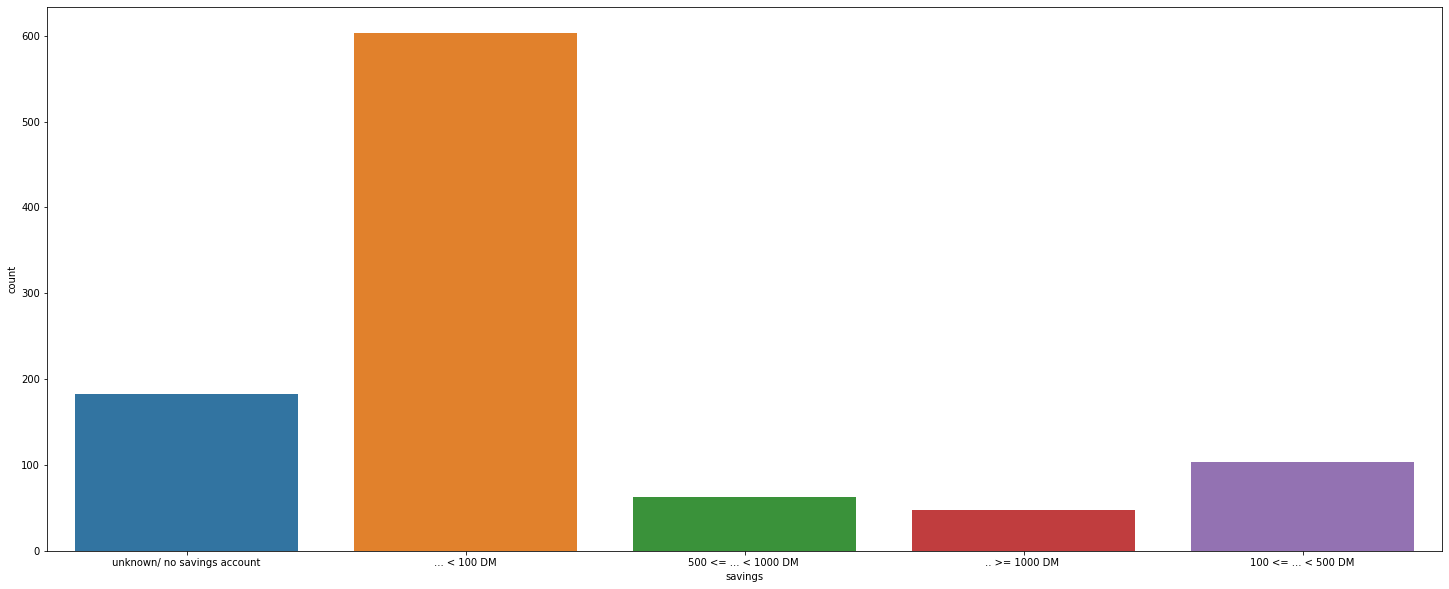

In [18]:
plt.figure(figsize=(25,10))
sns.countplot(data['savings'])

Another positive insight from this data is that majority of the population have some sort of savings account and have balance in them. 

The proportion of people with a savings and balance is quiet large as compared to people who don't have any savings account. However what is disconcerting is that a large portion of the former set have quiet low balance in their accounts (< 100 DM). 

We need to delve deeper to find how this impacts their credits, whether they rely more on credits & whether they are able to pay back their credits on time. Also we need to check if these same people are also taking big-ticket loans

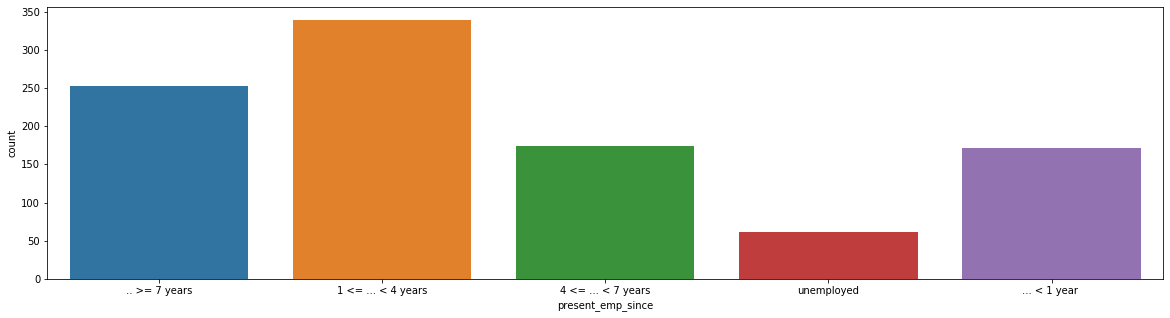

In [19]:
plt.figure(figsize=(20,5))
sns.countplot(data['present_emp_since'])

A majority of the population seems to have a stable job with most people having been employed for > 1 year. However, there are also a statistically significant (20%) portion of the population who are either unemployed or have been employed for less than 1 year. 

We need to delve deeper to find how this impacts their credits, whether they rely more on credits & whether they are able to pay back their credits on time. Also we need to check if these same people are also taking big-ticket loans

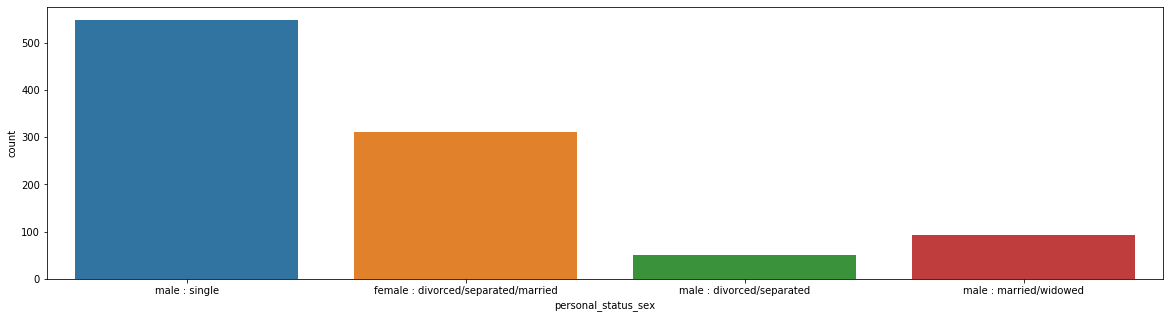

In [20]:
plt.figure(figsize=(20,5))
sns.countplot(data['personal_status_sex'])

The data is disproportionately skewed for men, with almost 70% of the data representing men.

Of these, around 55% of the covered men are SINGLE, with jus about 5% of the population being DIVORCED/SEPERATED men, and around 10% of the men being MARRIED/WIDOWED. 

We will need to understand whether there is any observable pattern in the credit ratings of men vs women, and in between men for married vs single/widowed/seperated 

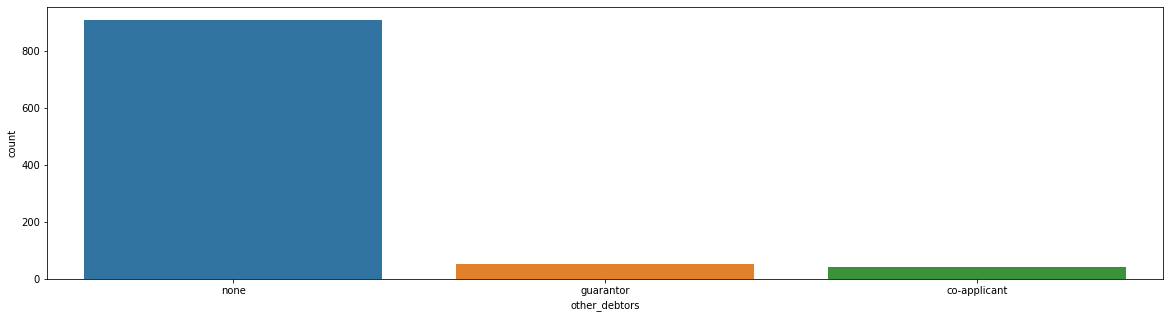

In [21]:
plt.figure(figsize=(20,5))
sns.countplot(data['other_debtors'])

Common sense states that people who are co-applicants in loans are at a higher credit default risk than guarantors, who are in turn at an higher risk as against people without any credits.

This data shows that a majority of the people don't have credits with other lendors and this should be a good sign. But we need to check, how is the relationship between people who have other debts & have taken big-ticket loans from this bank. These might me potentially risky customers

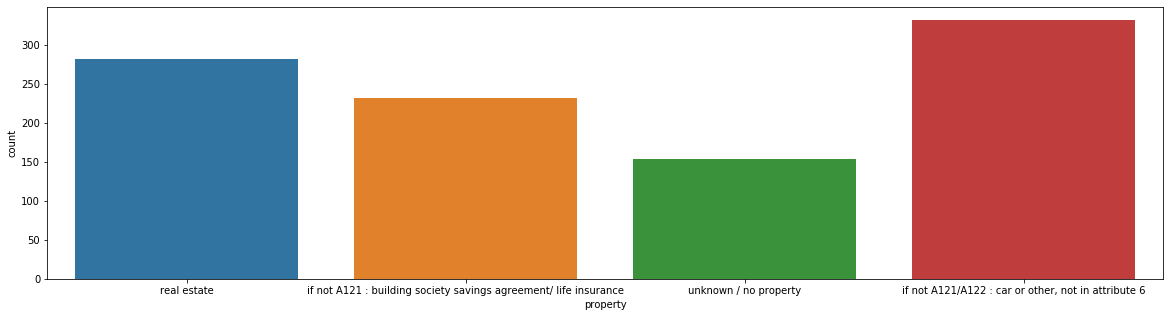

In [22]:
plt.figure(figsize=(20,5))
sns.countplot(data['property'])

The above distribution seems to indicate the distribution of available collaterals with the dataset.

A major portion of the dataset seems to have some form of property as collateral, with a significant number having a tangible & high-value collateral as real-estate. The proportion of people who have no such property/collateral is 15%, but this number is not statistically insignificant.

What we need to find is how many of the high-value collateral owners (judging from above as A121/A122) have taken high-value loans & how many high-value loan takers have low-value collaterals, which may make the process of recovery, in case of a default, more difficult

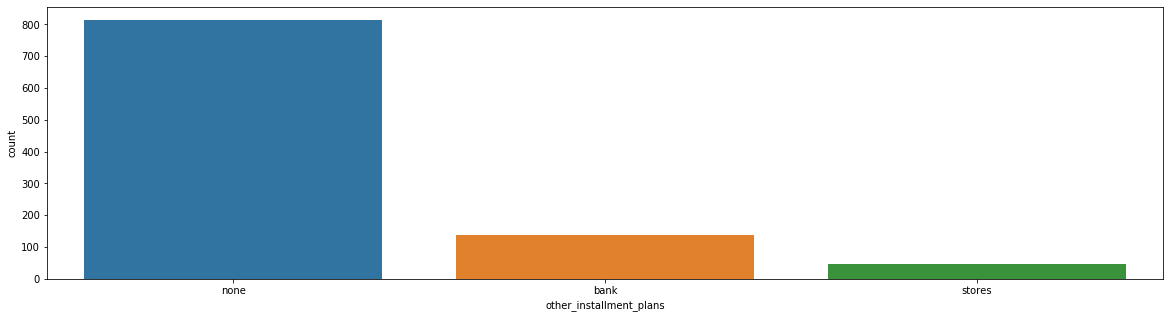

In [23]:
plt.figure(figsize=(20,5))
sns.countplot(data['other_installment_plans'])

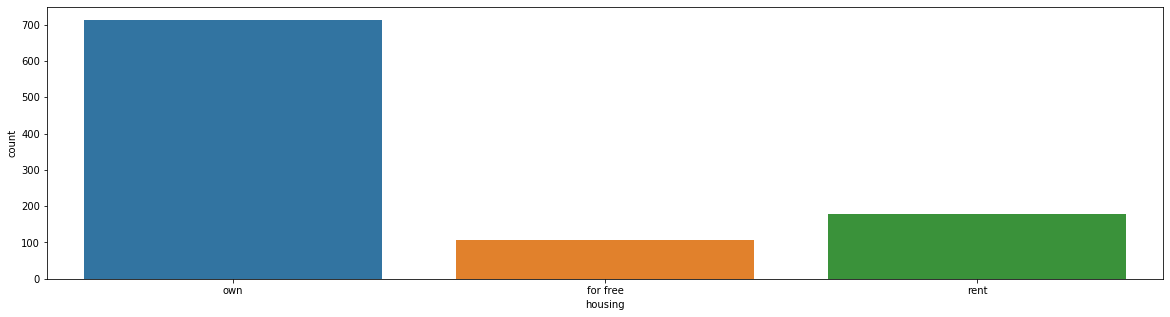

In [24]:
plt.figure(figsize=(20,5))
sns.countplot(data['housing'])

A significant portion of the dataset has their own residency. This is followed by people staying on rent, followed by people staying in free-housing

While the former is a quiet safe venture for provding loans, we need to check if big-ticket loans have been provided to people who don't have a tangible, high-value collateral like a own house. These cases might be potentially high-risk defaulters, based on other parameters like unstable job, many dependents, multiple installments, multiple credits, etc.

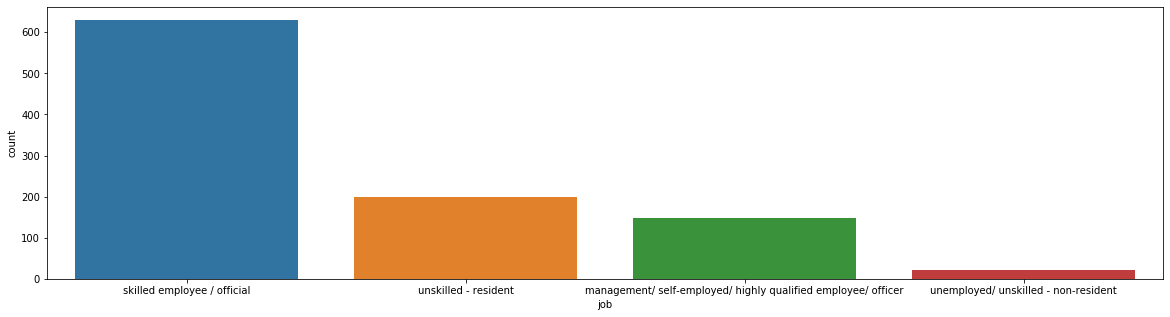

In [25]:
plt.figure(figsize=(20,5))
sns.countplot(data['job'])

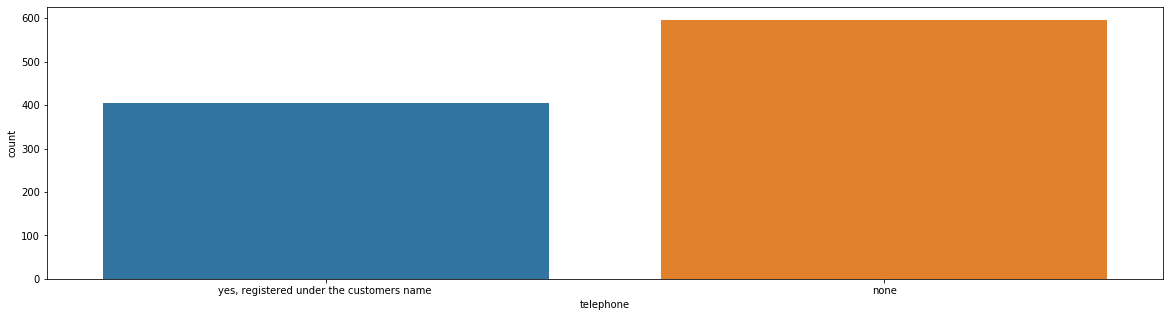

In [26]:
plt.figure(figsize=(20,5))
sns.countplot(data['telephone'])

A significant number of people have a registered telephone in their name. However we can't determine whether this is a landline or a mobile phone. In any case, a person with a registered contact number is more reachable than a person without so. The latter will require additional scrutiny before handing out a loan as in case of a default, recovery will be extremely difficult.

In case we are referring to telephone as a fixed-phone, then these customers are much more reliable than those without a telephone, as having a telephone in this case ensures the person has both a proper contact detail, as well as a fixed address. Thus in cases of defaults, recovery from these customers would be more easy

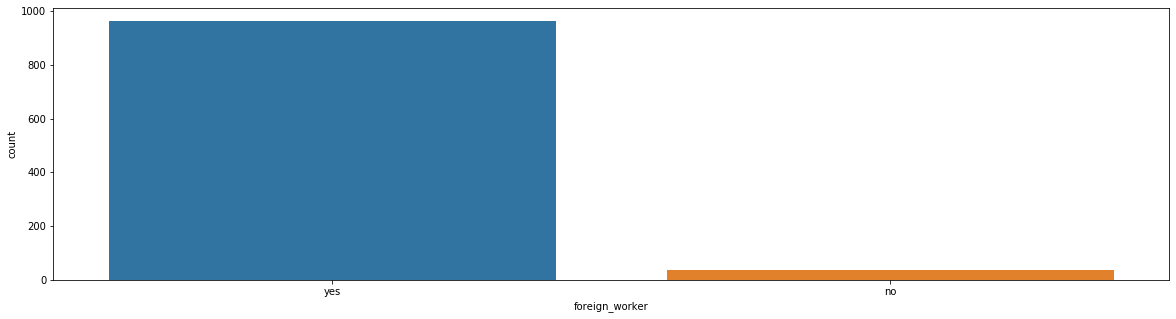

In [27]:
plt.figure(figsize=(20,5))
sns.countplot(data['foreign_worker'])

This is the last feature on which we will be performing our univariate analysis. As evident from the plot above, almost 90%+ of the data is a foreign_worker, while the rest are resident Germans.

A beautiful insight that can be drawn from the above is that inspite of them being outsiders, a lot of foreign workers have been able to successfully find stable jobs, marry, have their own homes, save & overall have a quiet normal life judging from their credit_history & purpose of taking those credits. Kudos to them. **:-)**

Of the 20 features present in the dataset, there are only 3 continuous numerical variables. The rest, although some of them have been stored as numerical data, are categorical in nature. Thankfully, the opposite is not true.

We need to encode all of these variables, so that we can use them for prediction.

**The below variables need dummy-encoding:**
1. credit_history
2. purpose
3. personal_status_sex
4. other_installment_plans
5. housing
6. job
7. telephone
8. foreign_worker

**The below items, although categorical in nature, need label encoding as the items have ordered data:**
1. account_check_status
2. present_emp_since
3. savings
4. other_debtors
5. property


**Dummy Encoding for the above column**

In [28]:
data = pd.get_dummies(data, columns=['credit_history'])
data = pd.get_dummies(data, columns=['purpose'])
data = pd.get_dummies(data, columns=['personal_status_sex'])
data = pd.get_dummies(data, columns=['other_installment_plans'])
data = pd.get_dummies(data, columns=['housing'])
data = pd.get_dummies(data, columns=['job'])
data = pd.get_dummies(data, columns=['telephone'])
data = pd.get_dummies(data, columns=['foreign_worker'])

data = pd.get_dummies(data, columns=['account_check_status'])
data = pd.get_dummies(data, columns=['present_emp_since'])
data = pd.get_dummies(data, columns=['savings'])
data = pd.get_dummies(data, columns=['other_debtors'])
data = pd.get_dummies(data, columns=['property'])

**Label Encoding for required columns**

In [29]:
# Print Shape of model data
data.shape

(1000, 61)

So after encoding, both Label & Dummy(OneHotEncoding), we have derived 45 features from the initial 20

### Check for highly correlated variables but don't required any treatment for this use case

In [30]:
data.corr()

,duration_in_month,credit_amount,installment_as_income_perc,present_res_since,age,credits_this_bank,people_under_maintenance,credit_history_all credits at this bank paid back duly,credit_history_critical account/ other credits existing (not at this bank),credit_history_delay in paying off in the past,...,savings_100 <= ... < 500 DM,savings_500 <= ... < 1000 DM,savings_unknown/ no savings account,other_debtors_co-applicant,other_debtors_guarantor,other_debtors_none,property_if not A121 : building society savings agreement/ life insurance,"property_if not A121/A122 : car or other, not in attribute 6",property_real estate,property_unknown / no property
duration_in_month,1.000000,0.624984,0.074749,0.034067,-0.036136,-0.011284,-0.023834,0.033728,-0.075575,0.136927,...,0.051587,-0.040257,0.071185,0.029698,-0.039594,0.009993,-0.056706,0.119486,-0.242586,0.212838
credit_amount,0.624984,1.000000,-0.271316,0.028926,0.032716,0.020795,0.017142,0.005923,-0.041807,0.113552,...,0.013546,-0.064256,0.106546,0.079076,-0.065237,-0.004116,-0.032556,0.075679,-0.248338,0.248922
installment_as_income_perc,0.074749,-0.271316,1.000000,0.049302,0.058266,0.021669,-0.071207,0.030339,0.041089,-0.014597,...,-0.015356,-0.023186,0.018367,-0.013048,-0.006429,0.013823,-0.020628,0.017023,-0.034555,0.044990
present_res_since,0.034067,0.028926,0.049302,1.000000,0.266419,0.089625,0.042643,0.027694,0.088460,-0.020351,...,0.017789,0.032702,0.080564,0.001623,-0.028334,0.020553,-0.023708,-0.041462,-0.085194,0.188028
age,-0.036136,0.032716,0.058266,0.266419,1.000000,0.149254,0.118201,0.014360,0.163681,0.016129,...,-0.075302,0.030988,0.077811,-0.018357,-0.023923,0.030822,-0.028686,-0.143485,0.011538,0.206368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
other_debtors_none,0.009993,-0.004116,0.013823,0.020553,0.030822,0.022966,-0.005566,-0.054917,0.017014,0.087314,...,-0.004769,0.083031,0.053597,-0.645721,-0.731408,1.000000,-0.011616,0.123386,-0.128353,0.012611
property_if not A121 : building society savings agreement/ life insurance,-0.056706,-0.032556,-0.020628,-0.023708,-0.028686,-0.009946,-0.006284,-0.036962,0.005330,0.021609,...,0.008605,-0.025508,0.058475,-0.018065,0.031327,-0.011616,1.000000,-0.387475,-0.344450,-0.234498
"property_if not A121/A122 : car or other, not in attribute 6",0.119486,0.075679,0.017023,-0.041462,-0.143485,0.010577,-0.073108,-0.012473,-0.033946,0.013372,...,0.040547,0.053173,-0.026118,-0.038680,-0.126856,0.123386,-0.387475,1.000000,-0.441818,-0.300785
property_real estate,-0.242586,-0.248338,-0.034555,-0.085194,0.011538,0.008568,0.020203,-0.029011,0.031123,-0.045625,...,-0.066139,-0.025300,-0.049463,0.004909,0.163513,-0.128353,-0.344450,-0.441818,1.000000,-0.267385


### Drop the original variables which are converted to dummy

*This is already been taken care of during dummy encoding. This can be verified from above, wherein we can't see the below columns*

1. credit_history
2. purpose
3. personal_status_sex
4. other_installment_plans
5. housing
6. job
7. telephone
8. foreign_worker

### Q3 Split Train/Test data 70:30 ratio( 1 Marks)
##### Hint:from sklearn.model_selection import train_test_split

In [31]:
X_train,X_test,y_train,y_test = train_test_split(data,y,test_size=0.3,random_state=1)

In [32]:
#Applying scaling to the X dataset
X_train.apply(zscore)
X_test.apply(zscore)

,duration_in_month,credit_amount,installment_as_income_perc,present_res_since,age,credits_this_bank,people_under_maintenance,credit_history_all credits at this bank paid back duly,credit_history_critical account/ other credits existing (not at this bank),credit_history_delay in paying off in the past,...,savings_100 <= ... < 500 DM,savings_500 <= ... < 1000 DM,savings_unknown/ no savings account,other_debtors_co-applicant,other_debtors_guarantor,other_debtors_none,property_if not A121 : building society savings agreement/ life insurance,"property_if not A121/A122 : car or other, not in attribute 6",property_real estate,property_unknown / no property
507,-0.477494,1.258735,-1.825742,-0.691218,-0.117271,-0.714759,2.134375,4.698609,-0.712417,-0.267261,...,2.893959,-0.288154,-0.447214,-0.185695,-0.237356,0.308043,1.747585,-0.728431,-0.613308,-0.392232
818,1.224947,4.484249,-0.912871,0.180065,0.724835,-0.714759,-0.468521,-0.212829,-0.712417,-0.267261,...,-0.345547,-0.288154,-0.447214,5.385165,-0.237356,-3.246300,-0.572218,1.372813,-0.613308,-0.392232
452,-0.720700,-0.206301,-0.912871,1.051349,-0.117271,0.973648,-0.468521,-0.212829,-0.712417,-0.267261,...,-0.345547,-0.288154,-0.447214,-0.185695,-0.237356,0.308043,1.747585,-0.728431,-0.613308,-0.392232
368,1.224947,0.039722,0.912871,-0.691218,0.631268,-0.714759,2.134375,-0.212829,-0.712417,-0.267261,...,-0.345547,-0.288154,-0.447214,-0.185695,-0.237356,0.308043,-0.572218,1.372813,-0.613308,-0.392232
242,2.197770,0.454774,0.000000,1.051349,-1.052944,0.973648,2.134375,-0.212829,-0.712417,-0.267261,...,-0.345547,-0.288154,-0.447214,-0.185695,-0.237356,0.308043,-0.572218,-0.728431,-0.613308,2.549510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,-0.234288,0.450834,0.000000,-0.691218,-0.304406,-0.714759,-0.468521,-0.212829,-0.712417,-0.267261,...,-0.345547,-0.288154,-0.447214,-0.185695,-0.237356,0.308043,-0.572218,1.372813,-0.613308,-0.392232
415,1.224947,0.897758,-0.912871,-0.691218,-0.023704,0.973648,2.134375,-0.212829,1.403673,-0.267261,...,-0.345547,-0.288154,-0.447214,-0.185695,-0.237356,0.308043,1.747585,-0.728431,-0.613308,-0.392232
61,-0.477494,-0.643914,0.912871,1.051349,1.379806,0.973648,-0.468521,-0.212829,1.403673,-0.267261,...,-0.345547,-0.288154,2.236068,-0.185695,4.213075,-3.246300,-0.572218,-0.728431,1.630502,-0.392232
347,0.252123,0.151453,-1.825742,1.051349,-1.146512,-0.714759,-0.468521,-0.212829,-0.712417,-0.267261,...,-0.345547,3.470371,-0.447214,-0.185695,-0.237356,0.308043,-0.572218,-0.728431,-0.613308,2.549510


### Q4 Build Random Forest Model( 1 Marks)
#### Hint:from sklearn.ensemble import RandomForestClassifier using n_jobs=2,n_estimators=500,criterion="entropy",random_state=9999

In [33]:
rfcl = RandomForestClassifier(n_jobs=2,n_estimators=500,criterion="entropy",random_state=9999)
rfcl = rfcl.fit(X_train,y_train)

y_pred_test_rfcl = rfcl.predict(X_test)

### Q5 Calculate Confusion Matrix and Accuracy score (1 Marks)
##### Hint: Use confusion_matrix and accuracy_score

In [34]:
metrics.confusion_matrix(y_test,y_pred_test_rfcl)

array([[200,  14],
       [ 58,  28]])

In [35]:
metrics.accuracy_score(y_test,y_pred_test_rfcl)

0.76

### Q6 Show the list of the features importance( 1 Marks)

In [36]:
important_features = pd.Series(data=rfcl.feature_importances_,index=data.columns)
important_features.sort_values(ascending=False,inplace=True)
print("The list of important features, ordered in a descending order of importance",end='\n\n')
print (important_features)

The list of important features, ordered in a descending order of importance

credit_amount                               0.101710
age                                         0.078145
duration_in_month                           0.072253
account_check_status_no checking account    0.046639
installment_as_income_perc                  0.038432
                                              ...   
foreign_worker_yes                          0.002755
purpose_repairs                             0.002421
job_unemployed/ unskilled - non-resident    0.002028
purpose_furniture/equipment                 0.001267
purpose_retraining                          0.001094
Length: 61, dtype: float64


### Q7 K-fold cross-validation( 2 Marks)
##### k-fold cross validation( without stratification)
##### Usually k is set as 10-20 in practical settings, depends on data set size

In [37]:
# Use below values
num_folds = 10
seed = 77

In [38]:
#Applying scaling to the dataset
data.apply(zscore)

,duration_in_month,credit_amount,installment_as_income_perc,present_res_since,age,credits_this_bank,people_under_maintenance,credit_history_all credits at this bank paid back duly,credit_history_critical account/ other credits existing (not at this bank),credit_history_delay in paying off in the past,...,savings_100 <= ... < 500 DM,savings_500 <= ... < 1000 DM,savings_unknown/ no savings account,other_debtors_co-applicant,other_debtors_guarantor,other_debtors_none,property_if not A121 : building society savings agreement/ life insurance,"property_if not A121/A122 : car or other, not in attribute 6",property_real estate,property_unknown / no property
0,-1.236478,-0.745131,0.918477,1.046987,2.766456,1.027079,-0.428290,-0.226991,1.553374,-0.31063,...,-0.338862,-0.259299,2.112932,-0.206768,-0.234206,0.320212,-0.549621,-0.704987,1.595650,-0.426653
1,2.248194,0.949817,-0.870183,-0.765977,-1.191404,-0.704926,-0.428290,-0.226991,-0.643760,-0.31063,...,-0.338862,-0.259299,-0.473276,-0.206768,-0.234206,0.320212,-0.549621,-0.704987,1.595650,-0.426653
2,-0.738668,-0.416562,-0.870183,0.140505,1.183312,-0.704926,2.334869,-0.226991,1.553374,-0.31063,...,-0.338862,-0.259299,-0.473276,-0.206768,-0.234206,0.320212,-0.549621,-0.704987,1.595650,-0.426653
3,1.750384,1.634247,-0.870183,1.046987,0.831502,-0.704926,2.334869,-0.226991,-0.643760,-0.31063,...,-0.338862,-0.259299,-0.473276,-0.206768,4.269750,-3.122929,1.819435,-0.704987,-0.626704,-0.426653
4,0.256953,0.566664,0.024147,1.046987,1.535122,1.027079,2.334869,-0.226991,-0.643760,3.21926,...,-0.338862,-0.259299,-0.473276,-0.206768,-0.234206,0.320212,-0.549621,-0.704987,-0.626704,2.343823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.738668,-0.544162,0.024147,1.046987,-0.399832,-0.704926,-0.428290,-0.226991,-0.643760,-0.31063,...,-0.338862,-0.259299,-0.473276,-0.206768,-0.234206,0.320212,-0.549621,-0.704987,1.595650,-0.426653
996,0.754763,0.207612,0.918477,1.046987,0.391740,-0.704926,-0.428290,-0.226991,-0.643760,-0.31063,...,-0.338862,-0.259299,-0.473276,-0.206768,-0.234206,0.320212,1.819435,-0.704987,-0.626704,-0.426653
997,-0.738668,-0.874503,0.918477,1.046987,0.215835,-0.704926,-0.428290,-0.226991,-0.643760,-0.31063,...,-0.338862,-0.259299,-0.473276,-0.206768,-0.234206,0.320212,-0.549621,1.418467,-0.626704,-0.426653
998,1.999289,-0.505528,0.918477,1.046987,-1.103451,-0.704926,-0.428290,-0.226991,-0.643760,-0.31063,...,-0.338862,-0.259299,-0.473276,-0.206768,-0.234206,0.320212,-0.549621,-0.704987,-0.626704,2.343823


In [39]:
#Validate the Random Forest model build above using k fold
k_fold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
print ("Cross-Validation Score for each of the K folds: ",cross_val_score(rfcl, data, y, cv=k_fold, n_jobs=1))

Cross-Validation Score for each of the K folds:  [0.88 0.81 0.69 0.79 0.75 0.72 0.77 0.73 0.72 0.8 ]


In [40]:
kfold_cv_score = cross_val_score(rfcl, data, y, cv=k_fold, n_jobs=1)

In [41]:
#Calculate Mean score

In [42]:
kfold_cv_score.mean()

0.7659999999999999

In [43]:
# Calculate score standard deviation using std()

In [44]:
kfold_cv_score.std()

0.053141321022345714

# Q8 Print the confusion matrix( 1 Marks)

In [45]:
y_pred_cv_rfcl = cross_val_predict(rfcl,data,y,cv=k_fold, n_jobs=1)
metrics.confusion_matrix(y,y_pred_cv_rfcl)

array([[648,  52],
       [182, 118]])

# Q9.Classification accuracy: 
percentage of correct predictions and Calculate sensitivity (or True Positive Rate or Recall) and Precision.
( 1 Marks)

In [52]:
#Accuracy Score
print ("Accuracy Score of 10 fold Cross-Validated RandomForestClassifier:",metrics.accuracy_score(y,y_pred_cv_rfcl))

#Recall Score
print ("Recall Score of 10 fold Cross-Validated RandomForestClassifier:",metrics.recall_score(y,y_pred_cv_rfcl))

#Precision Score
print ("Precision Score of 10 fold Cross-Validated RandomForestClassifier:",metrics.precision_score(y,y_pred_cv_rfcl))

#F1 Score
print ("F1 Score of 10 fold Cross-Validated RandomForestClassifier:",metrics.f1_score(y,y_pred_cv_rfcl))

Accuracy Score of 10 fold Cross-Validated RandomForestClassifier: 0.766
Recall Score of 10 fold Cross-Validated RandomForestClassifier: 0.3933333333333333
Precision Score of 10 fold Cross-Validated RandomForestClassifier: 0.6941176470588235
F1 Score of 10 fold Cross-Validated RandomForestClassifier: 0.502127659574468


# Q10.Plot Receiver Operating Characteristic (ROC) Curves( 1 Marks)

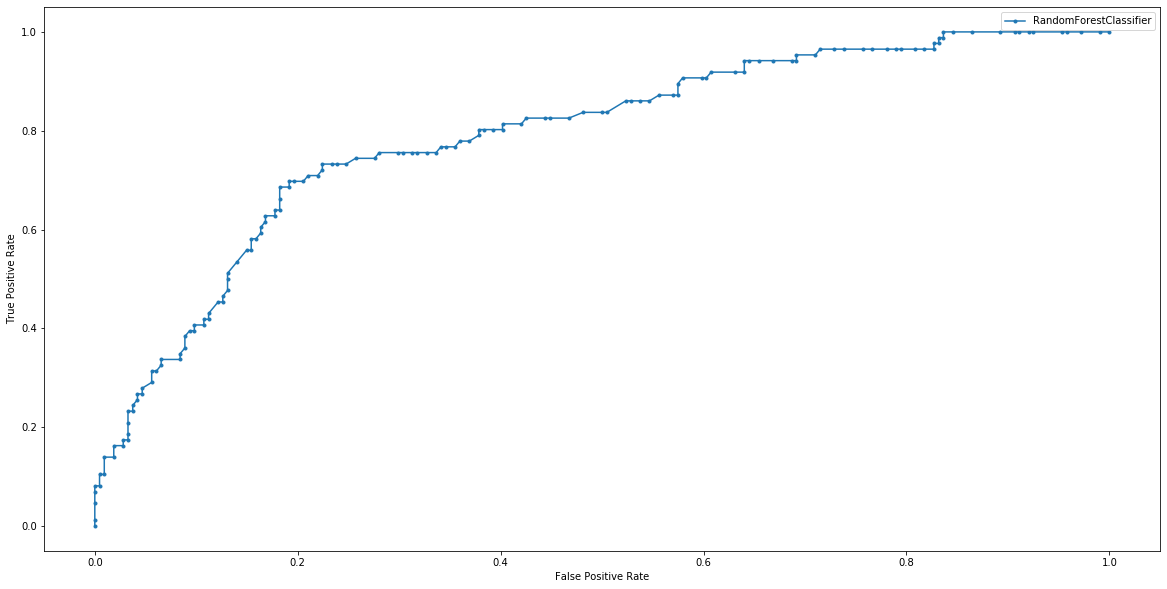

In [47]:
#Hint: Use roc_curve
# predict probabilities
lr_probs = rfcl.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

plt.figure(figsize=(20,10))
lr_fpr, lr_tpr, _ = metrics.roc_curve(y_test, lr_probs)
plt.plot(lr_fpr, lr_tpr, marker='.', label='RandomForestClassifier')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()

ROC curve can help you to choose a threshold that balances sensitivity and specificity in a way that makes sense for your particular context

# Q11. Calculate AUC(the percentage of the ROC plot that is underneath the curve) - optional

In [48]:
# calculate scores
lr_auc = metrics.roc_auc_score(y_test, lr_probs)

print('RandomForestClassifier: ROC AUC=%.3f' % (lr_auc))

RandomForestClassifier: ROC AUC=0.791


### Bootstrapping ( Bonus)
##### Given a dataset of size n, a bootstrap sample is created by sampling n instances uniformly from the data (with/without replacement)
##### Create a model with each bootstrap sample and validate it with the test set
##### Final result is calculated by averaging the accuracy of models

In [49]:
# Number of iterations for bootstrapping
bootstrap_iteration = 10
accuracy = []

In [50]:
for i in range(bootstrap_iteration):
    X_, y_ = resample(X_train, y_train)
    rfcl.fit(X_, y_)
    y_pred = rfcl.predict(X_test)
    
    acc = metrics.accuracy_score(y_pred, y_test)
    accuracy.append(acc)

In [51]:
accuracy = np.array(accuracy)
print('Accuracy Score')
print('Avearge: ', accuracy.mean())
print('Standard deviation: ', accuracy.std())

Accuracy Score
Avearge:  0.7443333333333333
Standard deviation:  0.015638272140986533
